#### *Analyze a family of RNNs all trained on the same data but with different hyperparameters.*

Essentially, most RNNs fit the muscle activity data (EMG) with almost the same loss.

(This is a very easy task from an ML standpoint.)

But not all such RNNs are equivalent as RNNs are overparametrized, and their internal behavior depends on hyperparameters. Here we investigate this dependence.

The cost function for the RNN
$$ \sum_{t,c}\|\hat{y}(t,c) - y(t,c)\|_2^2 + \lambda_1\|A\|_F^2 + \lambda_2\|C\|_F^2,$$
where $A$ and $C$ are the state-to-state and state-to-output matrices, respectively.

The RNN hyperparameters,
- $\lambda_1$
- $\lambda_2$
- $\sigma_w$ (std dev of noise injected into neurons during training

are compared against various measures of RNN activation trajectories
- mean curvature
- mean curvature (path length normalized)
- mean torsion (generalized curvature)
- trajectory "tangling" (a "global measure of curvature")
- path length
- dimensionality (participation ratio)
- average of the norms of the Jacobian evaluated at all path points
- "noise robustness"
- "structural robustness"

The latter two measures are obtained by resimulating the RNN and injecting noise to the state variables (noise robustness) or by adding a random perturbation to $A$ (structural robustness) and then finding the strength of noise required to drop the EMG fit to $R^2< 0.5$. This is tricky because a small perturbation in $A$ can result in EMG fits that are *qualitiatively* good but *quantitatively* bad (e.g. small frequency changes might result in a huge drop in $R^2$). Thus we use dynamic time warping (DTW) as a measure of loss instead of $MSE$ or $R^2$---first apply DTW then take $R^2$. This minor details turns out to actually make a difference.

----------

### TODO
Do:
- [DONE] Test for 1 condition only
- Lie stuff -- lie bracket, lie derivatives, etc
- regularize the RNN activations maybe
- [DONE] normalize by path length for curvature calculations
- [DONE] check to make sure dtw is working correctly
- plot ref lines for M1 data


# 0. Initial stuff

In [1]:
%reset -f
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

In [3]:
import numpy as np
import scipy.io as sio
import sklearn as sk

from sklearn import decomposition
from sklearn import metrics
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf

# For jupyter tensorboarding
from io import BytesIO
from functools import partial
import PIL.Image
from ipywidgets import FloatProgress

from IPython.display import clear_output, Image, display, HTML

import pickle
import os
import pprint as pp

from dtw import dtw
from cdtw import pydtw

from tqdm import tqdm # progress bar

In [4]:
import cyclingrnn.geometric as geo
from cyclingrnn import sigerr
from cyclingrnn.train import *

In [ ]:
sns.set_context()

In [36]:
# sns colormaps
#cmap = sns.color_palette('RdBu',5)[:2] + sns.color_palette('RdBu',5)[-2:]
#sns.set_palette(cmap)
sns.set_context('notebook', font_scale=1.0)

# Visualize results

In [44]:
def giant_regplot(df, logx=[]):
  col_set = df.columns
  for col in col_set:
    if len(df[col].unique())==1:
      df.drop(col, axis=1, inplace=True)
  cols = df.columns
  rows = df.columns
  
  isnumeric = [np.any([isinstance(i, (int, long, float, complex)) for i in df[c]]) for c in cols]  
  
  fact = 3
  num_cols = num_rows = len(cols)
  f, ax = plt.subplots(num_rows, num_cols, figsize=(fact*num_cols, fact*num_rows), sharey=False, sharex=False)
  for ir, row in enumerate(rows):
    for ic, col,  in enumerate(cols):
      logx_bool = col in logx
      if logx_bool:
        ax[ir, ic].set_xscale('log', basex=10)
      logy_bool = row in logx
      if logy_bool:
        ax[ir, ic].set_yscale('log', basex=10)

      if np.logical_xor(isnumeric[ir], isnumeric[ic]):
        sns.violinplot(x=col, y=row, data=df, ax=ax[ir, ic])
      elif (isnumeric[ir] and isnumeric[ic]):
        sns.regplot(col, row, df, logx=logx_bool, ax=ax[ir, ic], truncate=False)
        d_range = df[row].max() - df[row].min()
        ax[ir, ic].set_ylim([df[row].min()-0.1*d_range, df[row].max()+0.1*d_range])
        ax[ir, ic].set_xlim([df[col].min(), df[col].max()])

      if ir < num_rows-1:
        ax[ir, ic].xaxis.label.set_visible(False)
      if ic > 0:
        ax[ir, ic].yaxis.label.set_visible(False)



In [45]:
print df.columns

Index([u'activation', u'beta1', u'beta2', u'learning_rate', u'num_neurons',
       u'MSE', u'R2', u'noise_robustness', u'path_length',
       u'percent_tangling1', u'percent_tangling2', u'percent_tangling3',
       u'sim_num', u'struct_robustness', u'mean_curvature', u'mean_torsion'],
      dtype='object')


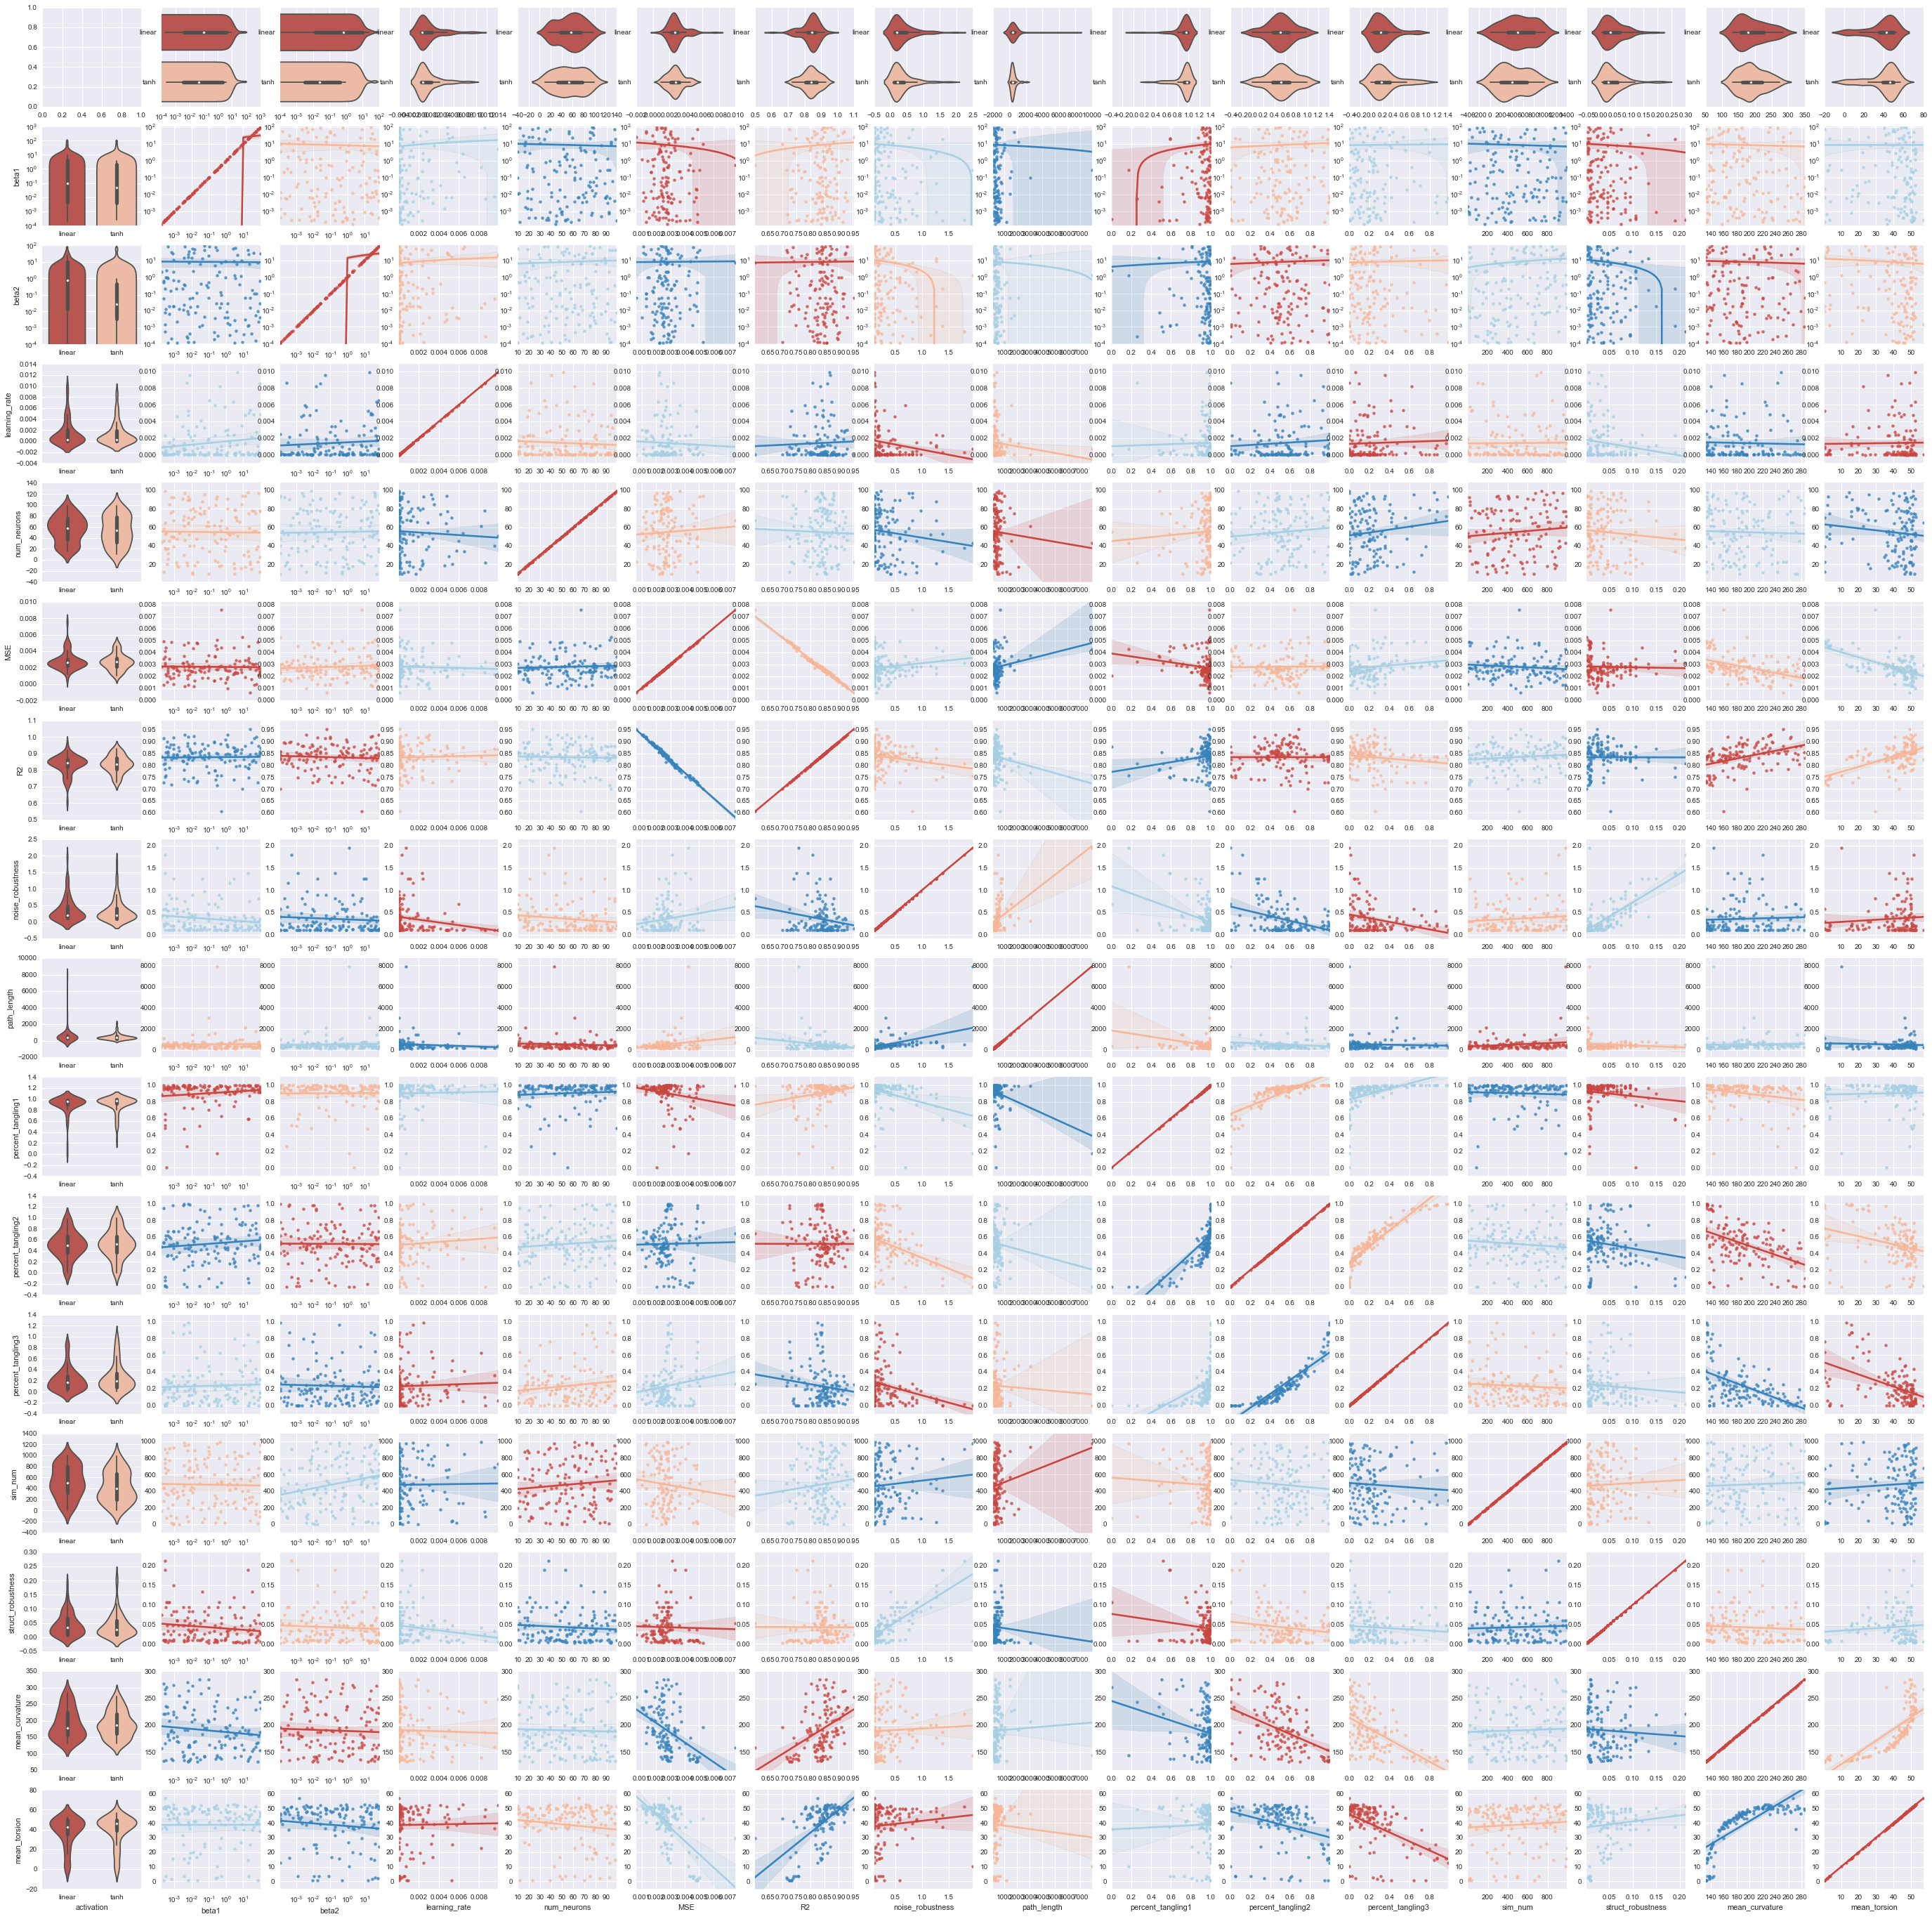

In [46]:
giant_regplot(df, ['beta1','beta2'])

In [ ]:
cols = ['percent_tangling1', 'percent_tangling2', 'percent_tangling3', 'struct_robustness'] # hyperparameters of the model
exclude = [u'monkey', u'activation', u'stddev_out', u'rnn_init'] # exclude these
rows = list(set(df.columns) - set(cols) - set(exclude)) # everything else
logx = [u'beta1', u'beta2', u'stddev_state'] # which cols get a log xscale

num_cols = len(cols)
num_rows = len(rows)

fact = 4
f, ax = plt.subplots(num_rows, num_cols, figsize=(fact*num_cols,fact*num_rows), sharey=False, sharex=False)

for ir, row in enumerate(rows):
  for ic, col,  in enumerate(cols):
    logx_bool = col in logx
    if logx_bool:
      ax[ir, ic].set_xscale('log', basex=10)
    sns.regplot(col, row, df, logx=logx_bool, ax=ax[ir, ic], truncate=False)
    if ir < num_rows-1:
      ax[ir, ic].xaxis.label.set_visible(False)
    if ic > 0:
      ax[ir, ic].yaxis.label.set_visible(False)
      
    d_range = df[row].max() - df[row].min()
    ax[ir, ic].set_ylim([df[row].min()-0.1*d_range, df[row].max()+0.1*d_range])
    ax[ir, ic].set_xlim([df[col].min(), df[col].max()])
      
plt.show()

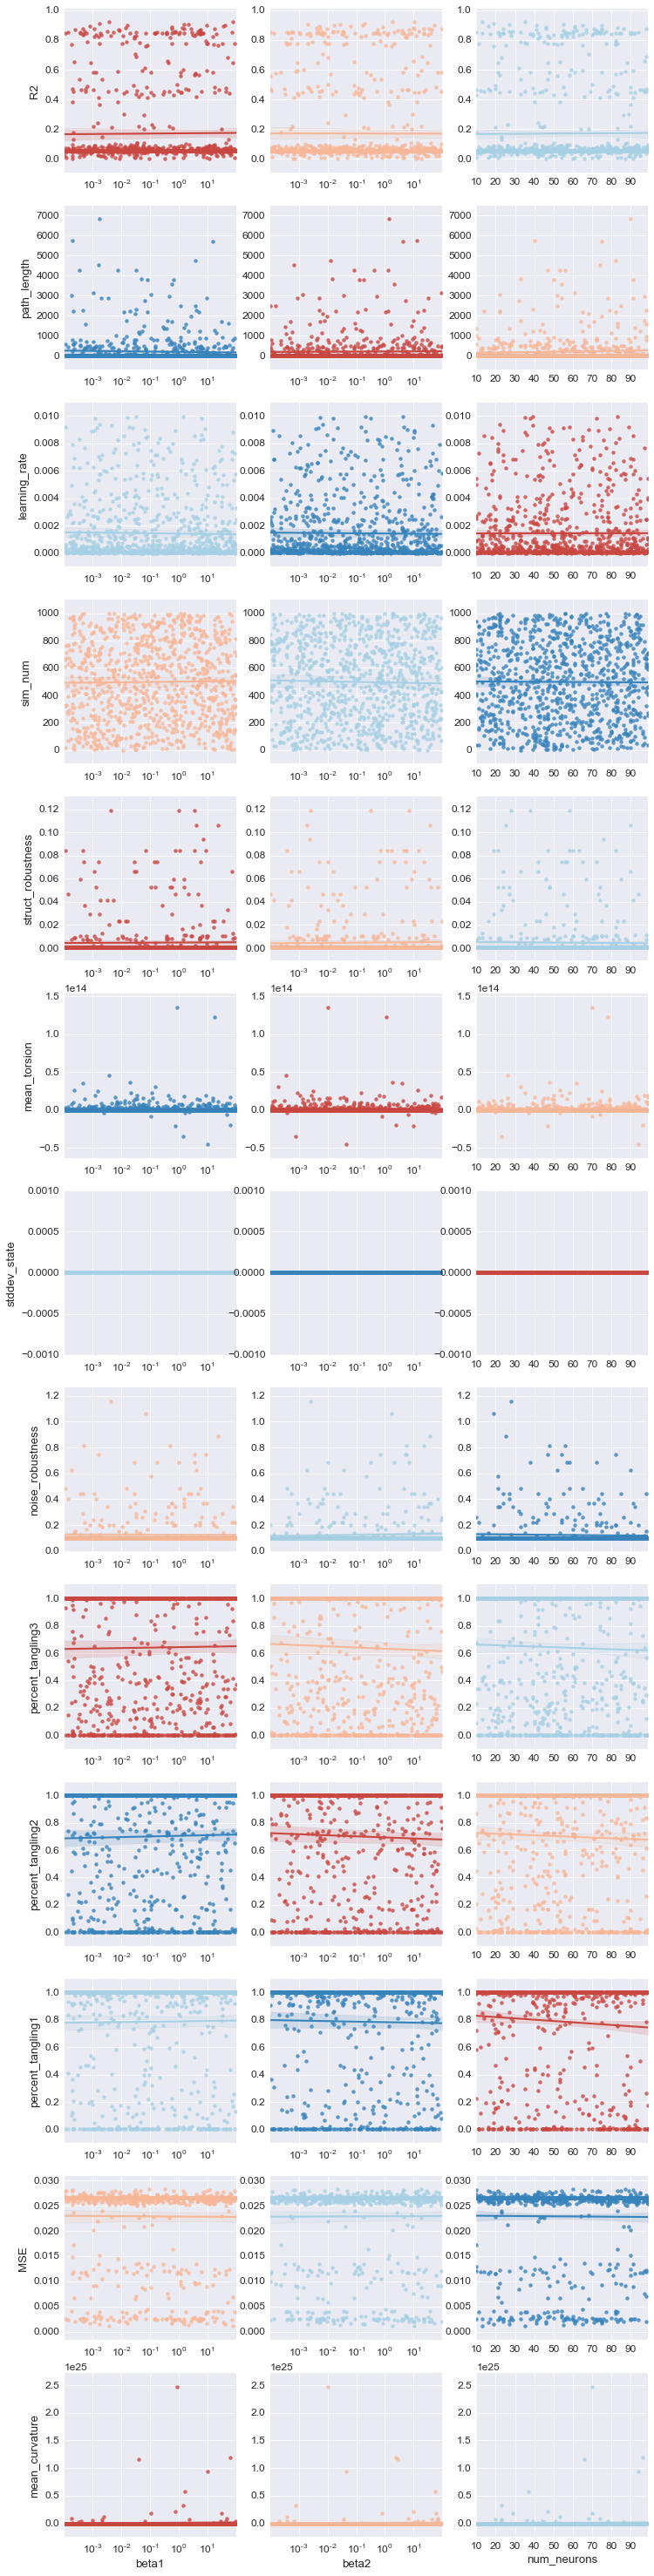

In [48]:
cols = [u'beta1', u'beta2',  u'num_neurons'] # hyperparameters of the model
exclude = [u'monkey', u'activation', u'stddev_out', u'rnn_init'] # exclude these
rows = list(set(df.columns) - set(cols) - set(exclude)) # everything else
logx = [u'beta1', u'beta2', u'stddev_state'] # which cols get a log xscale

num_cols = len(cols)
num_rows = len(rows)

fact = 4
f, ax = plt.subplots(num_rows, num_cols, figsize=(fact*num_cols,fact*num_rows), sharey=False, sharex=False)

for ir, row in enumerate(rows):
  for ic, col,  in enumerate(cols):
    logx_bool = col in logx
    if logx_bool:
      ax[ir, ic].set_xscale('log', basex=10)
    sns.regplot(col, row, df, logx=logx_bool, ax=ax[ir, ic], truncate=False)
    if ir < num_rows-1:
      ax[ir, ic].xaxis.label.set_visible(False)
    if ic > 0:
      ax[ir, ic].yaxis.label.set_visible(False)
      
    d_range = df[row].max() - df[row].min()
    ax[ir, ic].set_ylim([df[row].min()-0.1*d_range, df[row].max()+0.1*d_range])
    ax[ir, ic].set_xlim([df[col].min(), df[col].max()])
      
plt.show()

In [49]:
df.columns

Index([u'activation', u'beta1', u'beta2', u'learning_rate', u'monkey',
       u'num_neurons', u'rnn_init', u'stddev_out', u'stddev_state', u'MSE',
       u'R2', u'noise_robustness', u'path_length', u'percent_tangling1',
       u'percent_tangling2', u'percent_tangling3', u'sim_num',
       u'struct_robustness', u'mean_curvature', u'mean_torsion'],
      dtype='object')

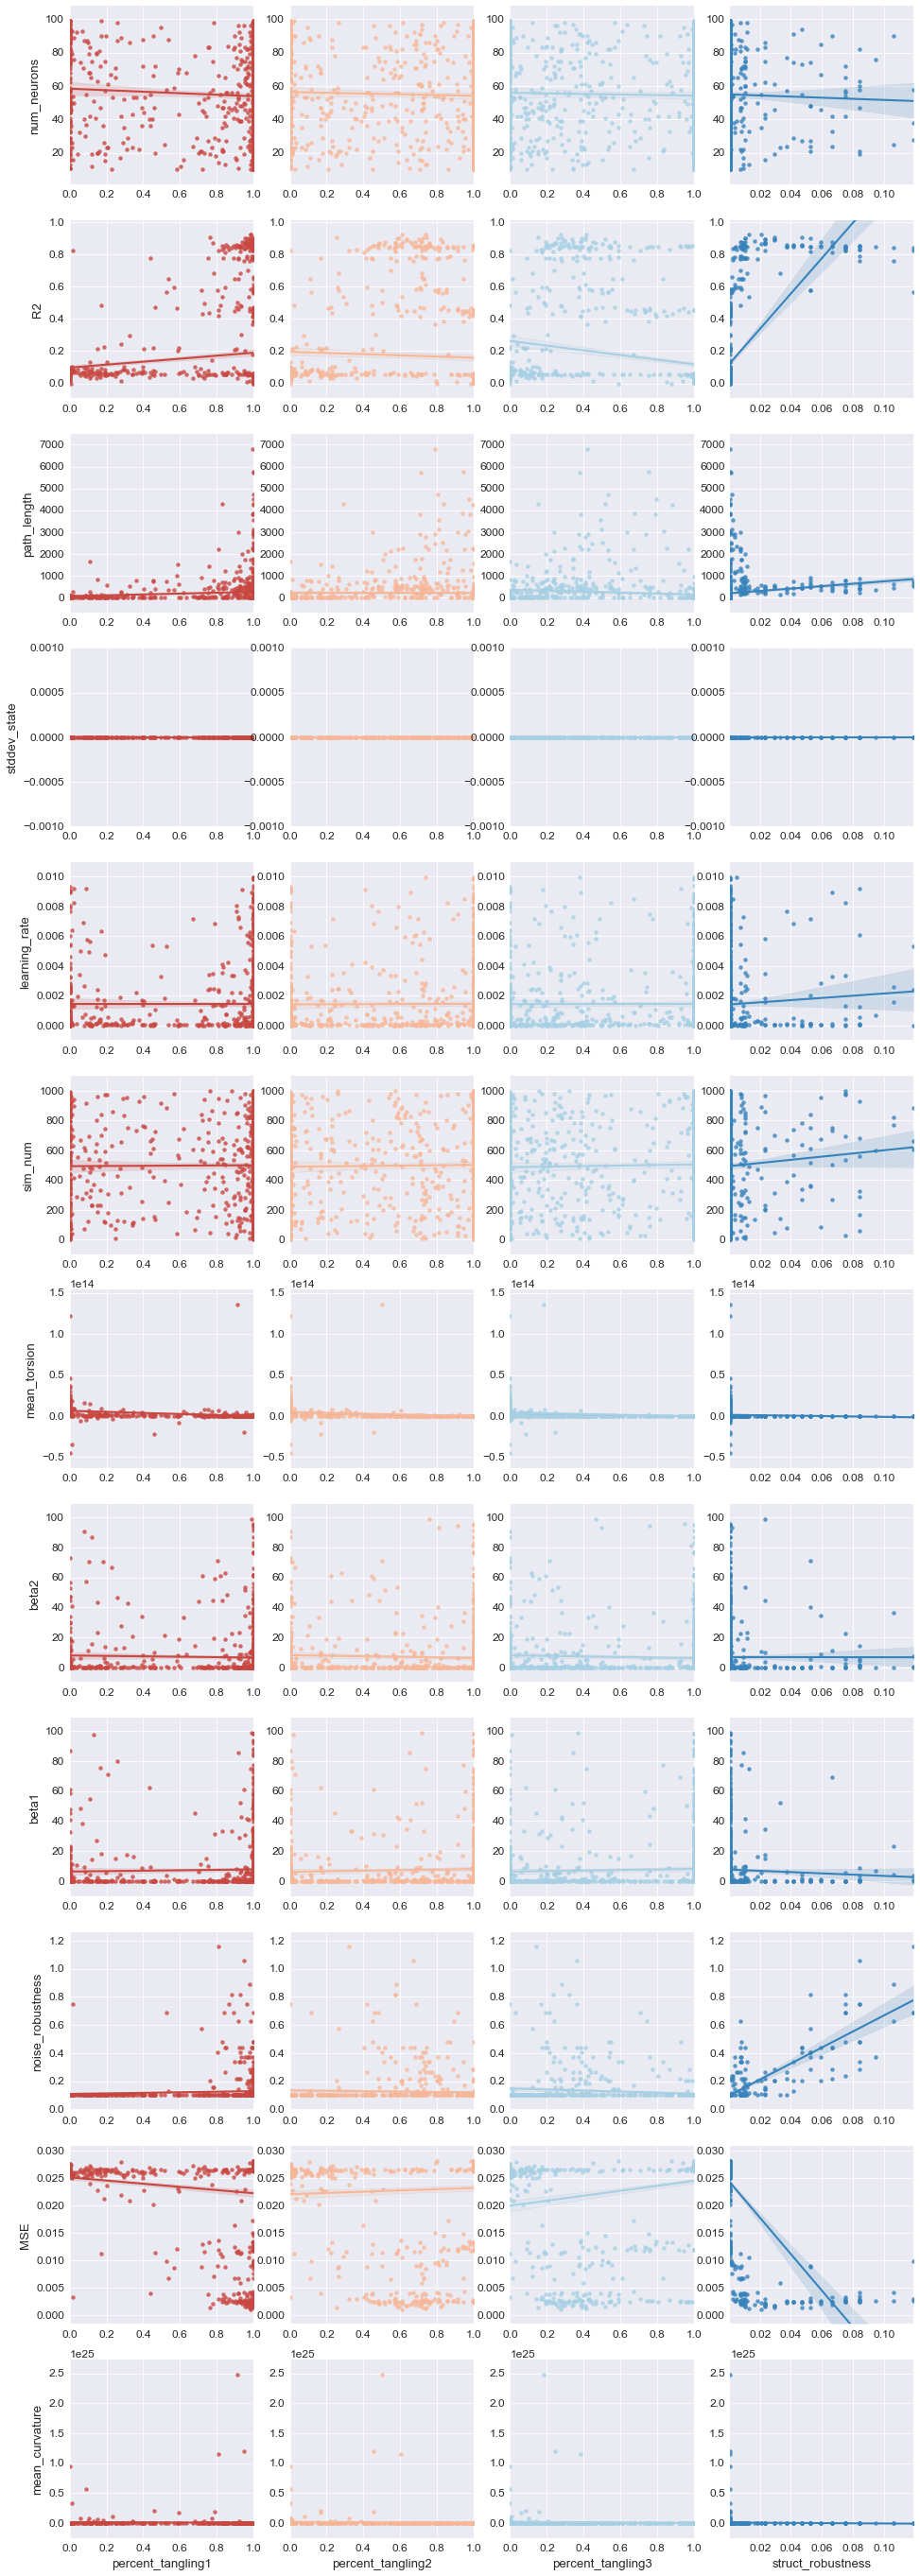

In [50]:
cols = ['percent_tangling1', 'percent_tangling2', 'percent_tangling3', 'struct_robustness'] # hyperparameters of the model
exclude = [u'monkey', u'activation', u'stddev_out', u'rnn_init'] # exclude these
rows = list(set(df.columns) - set(cols) - set(exclude)) # everything else
logx = [u'beta1', u'beta2', u'stddev_state'] # which cols get a log xscale

num_cols = len(cols)
num_rows = len(rows)

fact = 4
f, ax = plt.subplots(num_rows, num_cols, figsize=(fact*num_cols,fact*num_rows), sharey=False, sharex=False)

for ir, row in enumerate(rows):
  for ic, col,  in enumerate(cols):
    logx_bool = col in logx
    if logx_bool:
      ax[ir, ic].set_xscale('log', basex=10)
    sns.regplot(col, row, df, logx=logx_bool, ax=ax[ir, ic], truncate=False)
    if ir < num_rows-1:
      ax[ir, ic].xaxis.label.set_visible(False)
    if ic > 0:
      ax[ir, ic].yaxis.label.set_visible(False)
      
    d_range = df[row].max() - df[row].min()
    ax[ir, ic].set_ylim([df[row].min()-0.1*d_range, df[row].max()+0.1*d_range])
    ax[ir, ic].set_xlim([df[col].min(), df[col].max()])
      
plt.show()

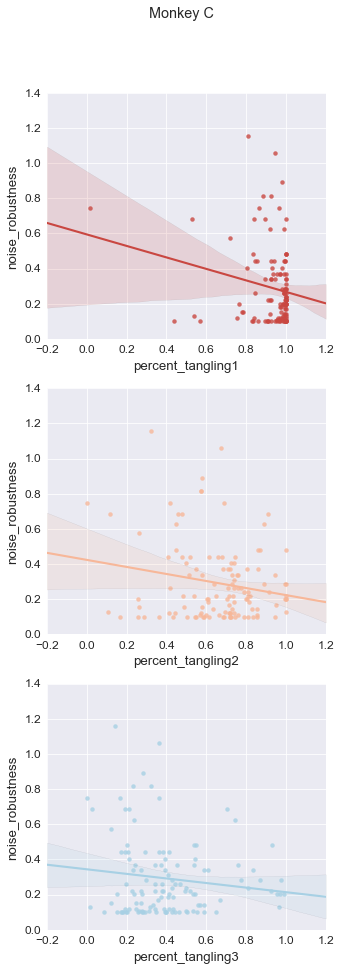

In [40]:
f, ax = plt.subplots(3, 1, figsize=(5,15))
f.suptitle('Monkey '+df.monkey.iloc[0])
sns.regplot('percent_tangling1', 'noise_robustness', df, ax=ax[0])
sns.regplot('percent_tangling2', 'noise_robustness', df, ax=ax[1])
sns.regplot('percent_tangling3', 'noise_robustness', df, ax=ax[2])

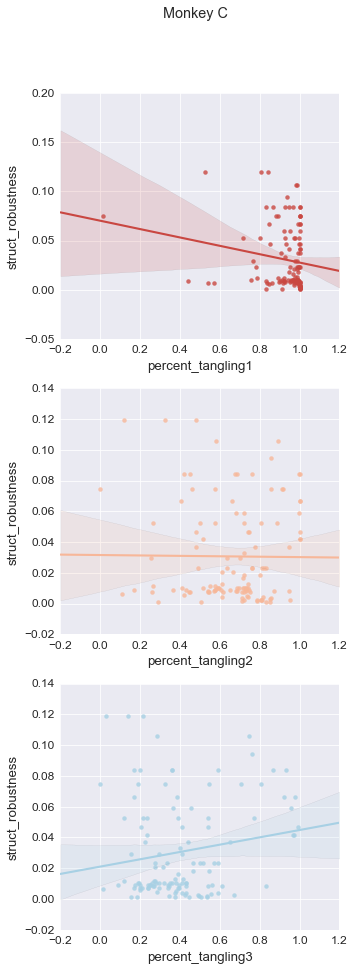

In [41]:
f, ax = plt.subplots(3, 1, figsize=(5,15))
f.suptitle('Monkey '+df.monkey.iloc[0])
sns.regplot('percent_tangling1', 'struct_robustness', df, ax=ax[0])
sns.regplot('percent_tangling2', 'struct_robustness', df, ax=ax[1])
sns.regplot('percent_tangling3', 'struct_robustness', df, ax=ax[2])

In [55]:
data_files = [i for i in os.listdir(RUN+'npsaves/') if i.endswith('x.npy')]
sim_nums = [i.replace('x.npy', '') for i in data_files]
param_files = [i+'params.pickle' for i in sim_nums]


In [62]:
for sim in [int(i) for i in sim_nums]:
  if sim % 50 == 0:
    print sim

1000
100
150
200
250
300
350
400
450
500
50
550
600
650
700
750
800
850
900
950


In [54]:
df

,activation,beta1,beta2,learning_rate,monkey,num_neurons,rnn_init,stddev_out,stddev_state,MSE,R2,noise_robustness,path_length,percent_tangling1,percent_tangling2,percent_tangling3,sim_num,struct_robustness,mean_curvature,mean_torsion
0,tanh,1.154169,0.327200,0.000276,C,51,orth,0.0,0.0,0.026517,0.055932,0.100000,0.002447,1.000000,1.000000,1.000000,445.0,0.001000,1.459017e+12,4.367784e+08
1,tanh,0.032898,0.003151,0.000078,C,36,orth,0.0,0.0,0.025935,0.072148,0.100000,6.451604,0.005882,0.000000,0.000000,961.0,0.001000,9.655595e+15,3.175825e+12
3,linear,3.557748,0.059164,0.000422,C,43,orth,0.0,0.0,0.026517,0.055951,0.100000,0.001260,1.000000,1.000000,1.000000,764.0,0.001000,5.936615e+11,2.017475e+08
4,tanh,7.394143,0.122696,0.000043,C,36,orth,0.0,0.0,0.026521,0.055849,0.100000,0.000954,1.000000,1.000000,1.000000,50.0,0.001000,1.453210e+12,5.961563e+08
5,tanh,0.002141,10.897285,0.000124,C,86,orth,0.0,0.0,0.026536,0.055369,0.100000,17.954565,0.097059,0.000000,0.000000,121.0,0.001000,2.635826e+23,1.192837e+11
6,tanh,0.005243,0.000526,0.000055,C,74,orth,0.0,0.0,0.002354,0.853543,0.201279,420.383596,1.000000,1.000000,0.970588,567.0,0.041711,1.378055e+02,2.464413e+01
7,tanh,0.074547,0.000110,0.000255,C,44,orth,0.0,0.0,0.025876,0.075125,0.100000,5.592842,0.000000,0.000000,0.000000,440.0,0.001000,6.389930e+15,2.885857e+12
8,linear,0.224870,24.927223,0.000618,C,12,orth,0.0,0.0,0.026540,0.055258,0.100000,1.084857,1.000000,1.000000,1.000000,243.0,0.001000,2.226328e+14,1.209004e+11
9,linear,0.039100,0.632416,0.000065,C,90,orth,0.0,0.0,0.026519,0.055914,0.100000,0.567376,1.000000,1.000000,1.000000,562.0,0.001000,3.375632e+14,9.933025e+10
10,linear,1.544855,0.155657,0.000215,C,52,orth,0.0,0.0,0.026517,0.055949,0.100000,0.001077,1.000000,1.000000,1.000000,914.0,0.001000,7.287152e+11,2.143137e+08


In [141]:
RUN

'../saves/170215C/'

In [142]:
sim = 1
x = np.load(RUN+'npsaves/'+str(sim)+'x.npy')
y = np.load(RUN+'npsaves/'+str(sim)+'y.npy')

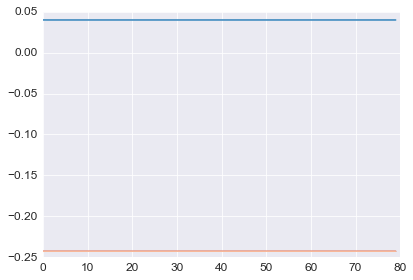

In [148]:
c = [0,1,2,3]
n = 4
plt.plot(x[:80,c,n])


In [138]:
mat = sio.loadmat('../cousFeb_processed.mat')

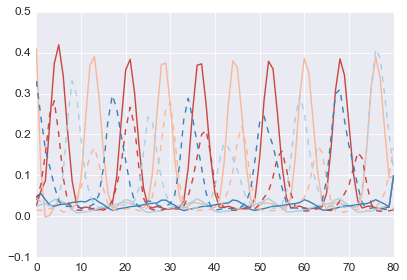

In [139]:
m = 4
plt.plot(y[:81,c,m])
plt.plot(mat['EMG'][5:,c,m], '--')

In [97]:
mat['EMG'].shape

(86, 4, 22)

In [105]:
from analyze_run import get_full_data
cur_params = {}
cur_params['monkey'] = 'C'
u_data, y_data = get_full_data(cur_params)

RUN:  ./saves/170215D/
conds:  [0, 1, 2, 3]
RUN:  ./saves/170215C/
conds:  [0, 1, 2, 3]


IOError: [Errno 2] No such file or directory: './cousFeb.mat'